In [20]:
import os
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import MWETokenizer

import csv
from gensim.models import Word2Vec
import os.path

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eliisabethein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
torch.manual_seed(0)
np.random.seed(0)

## Functions

In [22]:
def load_data(filename, max_sentence_len, with_labels=False):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename, encoding="utf8") as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len, with_labels)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

def get_batches_synthetic(data, batch_size):
    inputs = []
    targets = []

    for i in range(len(data) // batch_size):
        batch_sentences = data[i * batch_size:(i+1) * batch_size]

        input_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        target_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        for j, sentence in enumerate(batch_sentences):
                input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
                target_batch[j,0:len(sentence)-1,0] = sentence[1:]
        inputs.append(input_batch)
        targets.append(target_batch)
    
    return inputs, targets

### Encoder-decoder

In [23]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [24]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden
    

### VAE

In [25]:
class StochasticEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)

    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def forward(self, hidden_concatenated):
        mean = self.hidden_to_mean(hidden_concatenated)
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        return z, mean, log_variance

In [26]:
class StochasticDecoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
    def forward(self, z):
        hidden_concatenated = self.latent_to_hidden(z)
        return hidden_concatenated

In [27]:
# new VAE
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.stochastic_encoder = StochasticEncoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.stochastic_decoder = StochasticDecoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
        # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
        ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
        ## with this distribution it (kind of) works both without annealing and with annealing 
        ## (why??? who knows)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.encoder.embed.weight, -0.1, 0.1)
            nn.init.uniform_(self.decoder.embed.weight, -0.1, 0.1)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
    
    def latent_to_hidden(self, z):
        return self.stochastic_decoder.latent_to_hidden(z)
        
    # with teacher forcing
    def decode(self, hidden, x, x_lens=None, train=True): 
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None, dropout_rate=0, unk_index=0):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        z, mean, log_variance = self.stochastic_encoder.forward(hidden_concatenated)
        hidden_concatenated = self.stochastic_decoder.forward(z)
        hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        
        # word dropout
        if dropout_rate != 0.0:
            drop_probs = np.random.random_sample(x.shape)
            drop_probs[:, 0] = 1                  # set the <sos> token to 1 (always keep)
            for i, x_len in enumerate(x_lens):
                drop_probs[i, x_len:, 0] = 1      # set the <pad> tokens to 1 (always keep)
            dropped_x = x.copy()
            dropped_x[drop_probs < dropout_rate] = unk_index
            outputs = self.decode(hidden, dropped_x, x_lens)
        else:
            outputs = self.decode(hidden, x, x_lens)
            
        return mean, log_variance, outputs
    
    def calc_mi(self, x):
        # I(x, z) = E_xE_{q(z|x)}log(q(z|x)) - E_xE_{q(z|x)}log(q(z))
        mean, log_variance, _ = self.forward(x)
        _, batch_size, _ = mean.size()

        # E_{q(z|x)}log(q(z|x)) = -0.5*nz*log(2*\pi) - 0.5*(1+logvar).sum(-1)
        neg_entropy = (-0.5 * self.latent_dim * np.log(2 * np.pi)- 0.5 * (1 + log_variance).sum(-1)).mean()

        z = self.stochastic_encoder.reparametrize(mean, log_variance)
        mean, log_variance = mean.unsqueeze(0), log_variance.unsqueeze(0)

        log_density = -0.5 * (((z - mean) ** 2) / log_variance.exp()).sum(dim=-1) - \
            0.5 * (self.latent_dim * np.log(2 * np.pi) + log_variance.sum(-1))

        log_qz = log_sum_exp(log_density, dim=1) - np.log(batch_size)

        return (neg_entropy - log_qz.mean(-1)).item()

In [28]:
def loss_function(outputs, labels, mean, log_variance, seq_length, annealing_args=None, mask=None):
    if mask is not None:
        BCE = torch.zeros(mean.shape[1] * (seq_length - 1))
        BCE[mask] = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    else:
        BCE = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
    BCE = BCE.view(mean.shape[1], -1).sum(-1)
    KLD = -0.5 * (1 + log_variance - mean.pow(2) - log_variance.exp()).permute(1, 0, 2).sum(-1).squeeze(-1)
    if annealing_args is not None:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
    else:
        kl_weight = 1.0
    weighted_KLD = kl_weight * KLD
    loss = BCE + weighted_KLD
    return loss, BCE, KLD, weighted_KLD, kl_weight
    
def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)

### True posterior

In [29]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

def compute_true_posterior(latent_grid, vae, inputs, targets):
    log_true_posterior = compute_true_log_posterior(latent_grid, vae, inputs, targets)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(latent_grid, vae, inputs, targets):
    latent_grid = latent_grid.unsqueeze(0).expand(inputs.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    
    # Compute the true joint
    log_true_joint = compute_true_joint(latent_grid, vae, inputs, targets)
    
    # Normalize by marginalizing z
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=0, keepdim=True)
    return log_true_posterior

def compute_true_joint(latent_grid, vae, inputs, targets):
    n_sample, batch_size, latent_dim = latent_grid.size()
    seq_len = inputs.shape[1]
    # Compute prior p(z)
    normal = torch.distributions.normal.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
    log_true_prior = normal.log_prob(latent_grid).sum(dim=-1)
    
    # Compute conditional p(x | z)
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))
    tensor_target_batch = torch.tensor(targets.reshape(-1), dtype=torch.long)
    for i in range(latent_grid.size(0)):
        hidden_concatenated = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, inputs, train=False)
        log_true_conditional[i] = -nn.CrossEntropyLoss(reduction='none')(outputs, tensor_target_batch).view(batch_size, -1).sum(-1)
        
    # Compute joint p(x, z)
    log_true_joint = log_true_prior + log_true_conditional
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid):
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1)

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [31]:
def plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=3, 
                    iteration=None, save=True, plot_dir="plots"):
    latent_grid = generate_grid(-5, 5, step, latent_size)
    true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
    true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
    vae.eval()
    approximate_mean, _, _ = vae.forward(tracked_inputs)
    vae.train()
    plt.figure(figsize=(4,4))
    plt.plot(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100), color='silver', linestyle='dashed', linewidth=1.0, zorder=1)
    plt.plot(np.linspace(-1.5, 1.5, 100), np.linspace(0, 0, 100), color='silver', linestyle='dashed', linewidth=1.0, zorder=1)
    plt.plot(np.linspace(0, 0, 100), np.linspace(-1.5, 1.5, 100), color='silver', linestyle='dashed', linewidth=1.0, zorder=1)
    plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x', color='skyblue', s=15, zorder=2)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel("true posterior mean")
    plt.ylabel("approximate posterior mean")
    if save:
        plt.savefig("{}/iteration_{}.pdf".format(plot_dir, iteration), bbox_inches="tight")
    plt.show()

def plot_kl(kl_terms, kl_weights, plot_dir="plots", save=False):
    plot_step = 10
    x_axis = np.arange(len(kl_terms[::plot_step])) * plot_step
    fig, ax1 = plt.subplots(figsize=(8,2.5))
    ax1.plot(x_axis, kl_terms[::plot_step], color="skyblue", label="KL term value")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("KL term")
    ax2 = ax1.twinx()
    ax2.plot(x_axis, kl_weights[::plot_step], color="mediumorchid", label="KL weight")
    ax2.set_ylabel("KL weight")
    ax2.set_ylim(-0.05,1.05)
#     plt.legend()
    if save:
        plt.savefig("{}/annealing.pdf".format(plot_dir), bbox_inches="tight")
    plt.show()
    
def plot_losses(train_losses, val_losses, save=False, plot_dir="plots"):
    x_axis = np.arange(1,len(train_losses)+1)
    plt.figure(figsize=(5,4))
    plt.plot(x_axis, train_losses, label="training loss", color="skyblue")
    plt.plot(x_axis, val_losses, label="validation loss", color="mediumorchid")
    plt.xlabel("loss")
    plt.ylabel("epoch")
    plt.legend()
    if save:
        plt.savefig("{}/losses.pdf".format(plot_dir), bbox_inches="tight")
    plt.show()

## Experiments

In [32]:
def train(vae, inputs, targets, validation_inputs, validation_targets, epochs, vocab_size, hidden_size, 
          latent_size, max_sentence_length, num_layers=1, learning_rate=0.001,
          synthetic=False, input_lens=None, val_input_lens=None,               # text-related parameters
          dropout_rate=0.0, unk_index = None,                                  # word dropout parameters
          plot=False, plot_lim=1.5, step=1.0, tracked_inputs=None, tracked_targets=None,      # plotting
          annealing_args=None, is_aggressive=False, verbose=True, plot_dir="plots"):
    
    opt_dict = {"not_improved": 0, "lr": learning_rate, "best_loss": 1e4}
    
    decay_epoch = 2
    lr_decay = 0.5
    max_decay = 5

    enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_enc_optimizer = torch.optim.Adam(vae.stochastic_encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_dec_optimizer = torch.optim.Adam(vae.stochastic_decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    
    if annealing_args is not None:
        kl_terms = []
        kl_weights = []

    iteration = 0
    decay_cnt = 0
    kl_losses = []
    val_kl_losses = []
    total_epoch_losses = []
    val_total_epoch_losses = []
    
    if plot:
        if not os.path.exists(plot_dir):
            os.mkdir(plot_dir)
    
    if plot:
        plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, 
                        lim=plot_lim, iteration=iteration, plot_dir=plot_dir)
    
    previous_mi = -1
        
    for epoch in range(epochs):        
        for i in np.random.permutation(len(inputs)):
            
            inner_iter = 1
            random_i = i
            
            burn_num_words = 0
            burn_pre_loss = 1e4
            burn_cur_loss = 0
            while is_aggressive and inner_iter < 45:
                x = inputs[random_i]
                y = torch.tensor(targets[random_i].reshape(-1), dtype=torch.long)
                x_lens = input_lens[random_i] if not synthetic else None
                
                enc_optimizer.zero_grad()
                stoch_enc_optimizer.zero_grad()
                stoch_dec_optimizer.zero_grad()
                dec_optimizer.zero_grad()
                
                if synthetic:
                    burn_batch_size, burn_sents_len, _ = x.shape
                    burn_num_words += burn_sents_len * burn_batch_size
                else:
                    burn_num_words = np.sum(x_lens)
                
                mask = None
                mean, log_variance, outputs = vae(x, x_lens=x_lens)
                if not synthetic:
                    mask = (y < padding_index)
                    outputs = outputs[mask]
                    y = y[mask]
    
                loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)
                
                loss = loss_summary[0]
                burn_cur_loss += loss.sum().item()
                
                loss = loss.mean(dim=-1)
                loss.backward()
                
                clip_grad_norm_(vae.parameters(), 5.0)
                
                enc_optimizer.step()
                stoch_enc_optimizer.step()
                
                random_i = np.random.randint(0, len(inputs)- 1)
                if inner_iter % 15 == 0:
                    burn_cur_loss = burn_cur_loss / burn_num_words
                    if burn_pre_loss - burn_cur_loss < 0:
                        break
                    burn_pre_loss = burn_cur_loss
                    burn_cur_loss = 0
                    burn_num_words = 0
                inner_iter += 1
              
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None  
            
            mask = None
            mean, log_variance, outputs = vae(x, x_lens=x_lens, dropout_rate=dropout_rate, unk_index=unk_index)

            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]
            
            enc_optimizer.zero_grad()
            stoch_enc_optimizer.zero_grad()
            stoch_dec_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)
            loss = loss_summary[0]
            loss = loss.mean(dim=-1)
            
            if annealing_args is not None:
                kl_terms.append(np.mean(loss_summary[2].data.numpy()))
                kl_weights.append(loss_summary[4])     
            
            loss.backward()
            clip_grad_norm_(vae.parameters(), 5.0)
            
            if not is_aggressive:
                enc_optimizer.step()
                stoch_enc_optimizer.step()
                
            dec_optimizer.step()
            stoch_dec_optimizer.step()

            if (iteration % 100 == 0) and verbose:
                print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f} weighted KL: {:.3f} weight {:.3f}'.format(epoch+1, 
                            iteration, loss, loss_summary[1].mean(dim=-1).data.item(), \
                            loss_summary[2].mean(dim=-1).data.item(), \
                            loss_summary[3].mean(dim=-1).data.item(), loss_summary[4]))

            iteration += 1
            
            if annealing_args is not None:
                annealing_args['step'] = iteration
        
        if is_aggressive:
            vae.eval()
            current_mi = calc_mi(vae, validation_inputs)
            vae.train()
            print('current_mi:', current_mi)
            if current_mi - previous_mi < 0:
                is_aggressive = False
                print("STOP AGGRESSIVE")

            previous_mi = current_mi
              
        # Validation
        vae.eval()
        with torch.no_grad():
            # NOTE!! if we want to do 100% dropout then we should also add it here.
            val_loss, val_kl, val_ppl = test_vae(vae, validation_inputs, validation_targets, val_input_lens, synthetic, annealing_args)
            loss, kl, ppl = test_vae(vae, inputs, targets, input_lens, synthetic, annealing_args)
            total_epoch_losses.append(loss)
            val_total_epoch_losses.append(val_loss)
            kl_losses.append(kl)
            val_kl_losses.append(val_kl)
            if verbose:
                print ('Epoch [{}/{}], Training Loss: {:.4f},  Training KL: {:.4f}, Training Perplexity: {:5.2f}, Validation Loss: {:.4f}, KL {:.4f}, Val Perplexity: {:5.2f}\n'
                       .format(epoch + 1, epochs, loss, kl, ppl, val_loss, val_kl, val_ppl))
            if plot:
                plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, 
                                lim=plot_lim, iteration=iteration, plot_dir=plot_dir)
                
            if val_loss > opt_dict["best_loss"]:
                opt_dict["not_improved"] += 1
                if opt_dict["not_improved"] >= decay_epoch:
                    opt_dict["best_loss"] = val_loss
                    opt_dict["not_improved"] = 0
                    opt_dict["lr"] = opt_dict["lr"] * lr_decay
                    #vae.load_state_dict(torch.load(args.save_path))
                    print('new lr: %f' % opt_dict["lr"])
                    decay_cnt += 1
                    
                    enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=opt_dict["lr"])
                    stoch_enc_optimizer = torch.optim.Adam(vae.stochastic_encoder.parameters(), lr=opt_dict["lr"])
                    stoch_dec_optimizer = torch.optim.Adam(vae.stochastic_decoder.parameters(), lr=opt_dict["lr"])
                    dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=opt_dict["lr"])
    
            else:
                opt_dict["not_improved"] = 0
                opt_dict["best_loss"] = val_loss
            
            if decay_cnt == max_decay:
                break
        vae.train()
    
    return_dict = {}
    return_dict['total_epoch_losses'] = np.array(total_epoch_losses)
    return_dict['val_total_epoch_losses'] = np.array(val_total_epoch_losses)
    return_dict['kl_losses'] = np.array(kl_losses)
    return_dict['val_kl_losses'] = np.array(val_kl_losses)

    if annealing_args is not None:
        return_dict['kl_terms'] = np.array(kl_terms)
        return_dict['kl_weights'] = np.array(kl_weights)
    
    return return_dict
        
def test_vae(vae, inputs, targets, input_lens, synthetic=False, annealing_args=None):
    kl_loss = ce_loss = 0
    num_words = num_sents = 0
    for i in np.random.permutation(len(inputs)):
        x = inputs[i]
        y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
        x_lens = input_lens[i] if not synthetic else None

        batch_size, sents_len, _ = x.shape
        if synthetic:
            num_words += batch_size * sents_len
        else:
            num_words = np.sum(x_lens)
        
        num_sents += batch_size
        
        mask = None
        mean, log_variance, outputs = vae(x, x_lens=x_lens)
        if not synthetic:
            mask = (y < padding_index)
            outputs = outputs[mask]
            y = y[mask]

        loss_summary = loss_function(outputs, y, mean, log_variance, max_sentence_length, annealing_args=annealing_args, mask=mask)

        loss_rc = np.sum(loss_summary[1].data.numpy())
        loss_kl = np.sum(loss_summary[3].data.numpy())
        
        ce_loss += loss_rc.item()
        kl_loss += loss_kl.item()

    #mutual_info = calc_mi(model, test_data_batch)

    loss = (kl_loss + ce_loss) / num_sents
    kl = kl_loss / num_sents
    ppl = np.exp(loss * num_sents / num_words)

    return loss, kl, ppl

    
def calc_mi(model, test_data_batch):
    mi = 0
    num_examples = 0
    for batch_data in test_data_batch:
        batch_size = batch_data.shape[0]
        num_examples += batch_size
        mutual_info = model.calc_mi(batch_data)
        mi += mutual_info * batch_size

    return mi / num_examples

In [38]:
def hist_active_units(vae, train_inputs, train_lengths=None):
    all_mus = None
    for i in range(len(train_inputs)):
        mus, _, _ = vae.forward(train_inputs[i], train_lengths[i] if train_lengths is not None else None)
        mus = mus.squeeze(0)
        if all_mus is None:
            all_mus = mus.detach().numpy()
        else:
            all_mus = np.vstack((mus.detach().numpy(), all_mus))
    plt.hist(np.var(all_mus, axis=0), bins=50)
    plt.show()
    return all_mus

## Load data

In [14]:
test_syn_data = np.loadtxt('synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('synthetic-data/synthetic_train.txt', dtype=int)

In [15]:
batch_size = 16

# load tracked inputs (for plotting)
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = np.expand_dims(np.array(tracked_inputs), axis=-1)
tracked_targets = np.expand_dims(np.array(tracked_targets), axis=-1)

# load data into batches
inputs, targets = get_batches_synthetic(train_syn_data, batch_size)
val_inputs, val_targets = get_batches_synthetic(test_syn_data[:2000], batch_size)
test_inputs, test_targets = get_batches_synthetic(test_syn_data[2000:], batch_size)

## Experiment 1: default parameters

In [53]:
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
max_sentence_length = 10

In [43]:
models_default = {}

### Basic

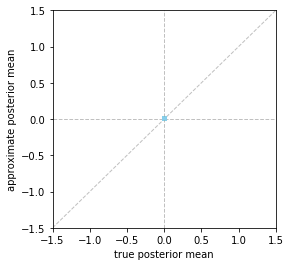

epoch 1 iteration 0 loss 62.159 CE 62.159 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 39.133 CE 39.132 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 200 loss 33.431 CE 33.430 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 300 loss 35.642 CE 35.638 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 1 iteration 400 loss 31.845 CE 31.845 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 500 loss 35.200 CE 35.200 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 600 loss 29.752 CE 29.752 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 700 loss 34.938 CE 34.937 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 800 loss 33.733 CE 33.733 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 900 loss 36.101 CE 36.100 KL 0.001 weighted KL: 0.001 weight 1.000
Epoch [1/30], Training Loss: 32.7088,  Training KL: 0.0580, Training Perplexity: 37.88, Validation Loss: 37.7764, KL 0.0580, Val Perplexity: 66.51



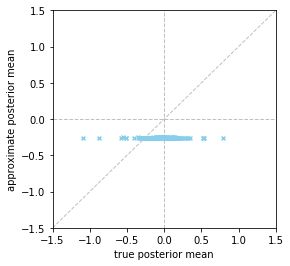

epoch 2 iteration 1000 loss 30.352 CE 30.294 KL 0.058 weighted KL: 0.058 weight 1.000
epoch 2 iteration 1100 loss 30.740 CE 30.740 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 2 iteration 1200 loss 32.213 CE 32.213 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1300 loss 32.985 CE 32.978 KL 0.007 weighted KL: 0.007 weight 1.000
epoch 2 iteration 1400 loss 35.260 CE 35.260 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1500 loss 31.629 CE 31.628 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 2 iteration 1600 loss 33.621 CE 33.621 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1700 loss 33.055 CE 33.055 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1800 loss 31.350 CE 31.350 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1900 loss 31.495 CE 31.495 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [2/30], Training Loss: 31.7914,  Training KL: 0.0010, Training Perplexity: 34.21, Validation Loss: 38.1451, KL 0.0010, Val Perplexity:

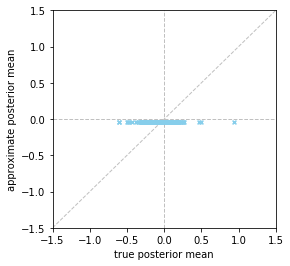

epoch 3 iteration 2000 loss 32.637 CE 32.636 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 3 iteration 2100 loss 29.881 CE 29.881 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2200 loss 35.630 CE 35.630 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2300 loss 30.997 CE 30.996 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 3 iteration 2400 loss 29.104 CE 29.104 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2500 loss 33.747 CE 33.744 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 3 iteration 2600 loss 33.878 CE 33.878 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2700 loss 30.679 CE 30.678 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2800 loss 34.245 CE 34.245 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2900 loss 31.475 CE 31.474 KL 0.001 weighted KL: 0.001 weight 1.000
Epoch [3/30], Training Loss: 31.2109,  Training KL: 0.0000, Training Perplexity: 32.07, Validation Loss: 37.9377, KL 0.0000, Val Perplexity:

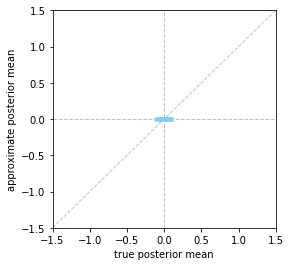

new lr: 0.025000
epoch 4 iteration 3000 loss 31.160 CE 31.160 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3100 loss 30.255 CE 30.250 KL 0.005 weighted KL: 0.005 weight 1.000
epoch 4 iteration 3200 loss 28.860 CE 28.860 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3300 loss 29.742 CE 29.742 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3400 loss 31.636 CE 31.636 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3500 loss 29.534 CE 29.534 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3600 loss 38.877 CE 38.877 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3700 loss 30.247 CE 30.247 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3800 loss 32.252 CE 32.252 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3900 loss 28.045 CE 28.045 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [4/30], Training Loss: 30.5680,  Training KL: 0.0318, Training Perplexity: 29.86, Validation Loss: 37.9582, KL 0.0318

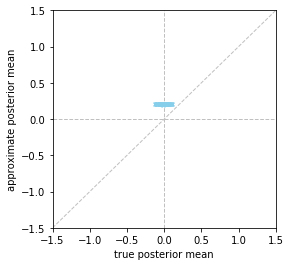

epoch 5 iteration 4000 loss 33.149 CE 33.118 KL 0.032 weighted KL: 0.032 weight 1.000
epoch 5 iteration 4100 loss 33.054 CE 33.054 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4200 loss 28.593 CE 28.593 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4300 loss 28.551 CE 28.551 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4400 loss 32.992 CE 32.991 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 5 iteration 4500 loss 32.836 CE 32.836 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4600 loss 29.978 CE 29.978 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4700 loss 31.431 CE 31.431 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4800 loss 33.886 CE 33.886 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4900 loss 29.765 CE 29.765 KL 0.000 weighted KL: 0.000 weight 1.000
Epoch [5/30], Training Loss: 30.1981,  Training KL: 0.0000, Training Perplexity: 28.66, Validation Loss: 37.9761, KL 0.0000, Val Perplexity:

In [ ]:
epochs = 30
learning_rate = 0.05
plot_dir = "plots_basic_default"

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

return_dict_basic_default = train(vae, inputs, targets, val_inputs, val_inputs, epochs, vocab_size, 
                                  hidden_size, latent_size, max_sentence_length, synthetic=True, 
                                  learning_rate=learning_rate, step=step, tracked_inputs=tracked_inputs, 
                                  tracked_targets=tracked_targets, plot_lim=1.5, verbose=True, plot=True, 
                                  plot_dir=plot_dir)
models_default['basic'] = vae
test_loss, test_kl, test_ppl = test_vae(vae, test_inputs, test_targets, None, synthetic=True)
print("test loss: {:.4f}, test KL: {:.4f}, test perplexity: {:.4f}".format(test_loss, test_kl, test_ppl))
mi_train = calc_mi(vae, inputs)
mi_test = calc_mi(vae, test_inputs)
print("mutual information: train {}, test {}".format(mi_train, mi_test))

### Annealing

In [ ]:
epochs = 30
learning_rate = 0.05
plot_dir = "plots_anneal_default"

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

return_dict_anneal_default = train(vae, inputs, targets, val_inputs, val_targets, epochs, 
                                   vocab_size, hidden_size, latent_size, max_sentence_length, plot=True, 
                                   learning_rate=learning_rate, synthetic=True, step=step, plot_lim=1.5, 
                                   annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
                                   tracked_targets=tracked_targets, plot_dir=plot_dir)
plot_kl(return_dict_anneal_default['kl_terms'], return_dict_anneal_default['kl_weights'], 
        save=True, plot_dir=plot_dir)
models_default['annealing'] = vae
test_loss, test_kl, test_ppl = test_vae(vae, test_inputs, test_targets, None, synthetic=True)
print("test loss: {:.4f}, test KL: {:.4f}, test perplexity: {:.4f}".format(test_loss, test_kl, test_ppl))

### Aggressive

In [ ]:
epochs = 30
learning_rate = 0.05
plot_dir = "plots_aggressive_default"

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

return_dict_aggressive_default = train(vae, inputs, targets, val_inputs, val_targets, 
                                       epochs, vocab_size, hidden_size, latent_size, max_sentence_length, 
                                       plot=True, learning_rate=learning_rate, synthetic=True, step=step, 
                                       tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, 
                                       plot_lim=1.5, is_aggressive=True, plot_dir=plot_dir)
models_default['aggressive'] = vae
test_loss, test_kl, test_ppl = test_vae(vae, test_inputs, test_targets, None, synthetic=True)
print("test loss: {:.4f}, test KL: {:.4f}, test perplexity: {:.4f}".format(test_loss, test_kl, test_ppl))

### Calculate mutual information

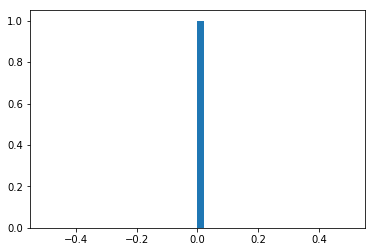

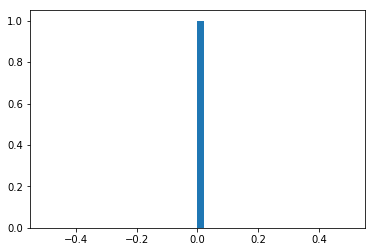

In [48]:
all_mus = hist_active_units(models_default['basic'], inputs)
all_mus = hist_active_units(models_default['basic'], test_inputs)

In [ ]:
all_mus = hist_active_units(models_default['annealing'], inputs)
all_mus = hist_active_units(models_default['annealing'], test_inputs)

In [ ]:
all_mus = hist_active_units(models_default['aggressive'], inputs)
all_mus = hist_active_units(models_default['aggressive'], test_inputs)

## Experiment 2: ?

In [ ]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.05
epochs = 30
max_sentence_length = 10

ks = [0.0005, 0.0025, 0.005]
first_steps = [0, 2500, 5000]
return_dicts = {}

for k in ks:
    for first_step in first_steps:
        print("hyperparameter setting: k={}, first_step={}".format(k, first_step))
        string_rep = "annealing_{}_{}".format(str(k).replace(".", ""), first_step)

        embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
        vae_anneal_new = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

        annealing_args = {'type':'logistic', 'step':0, 'k':k, 'first_step':first_step}
        return_dict = train(vae_anneal_new, inputs, targets, val_inputs, val_targets, epochs, vocab_size, hidden_size, 
                            latent_size, max_sentence_length, plot=True, learning_rate=learning_rate, synthetic=True, 
                            step=step, plot_lim=1.5, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
                            tracked_targets=tracked_targets, plot_dir="plots_{}".format(string_rep))
        plot_kl(return_dict['kl_terms'], return_dict['kl_weights'], save=True, plot_dir="plots_{}".format(string_rep))
        return_dicts[string_rep] = return_dict